In [38]:
using Random, Plots, Pkg
using Plots.PlotMeasures


ErrorException: syntax: { } vector syntax is discontinued

In [2]:
    #Hold Q values for each action
    mutable struct Actions
        A1      ::Float64
        A2      ::Float64
    end

    # Define a simple composite datatype to hold an Q value and the probablistic movement
    mutable struct State
        Q       ::Actions
        T       ::Union{Actions,Nothing}
        R       ::Float64
    end

    # Define the Tree data type for required task
    mutable struct DecisionTree
        state   ::State
        A1      ::Union{DecisionTree, Float64}
        A2      ::Union{DecisionTree, Float64}
    end

In [3]:
function buildStepTask(steps::Int;TM::Bool=false,branch=Nothing(),r::Float64=0.0)
    if steps == 1
        Q = Actions(0.0,0.0)
        TM ? T = Actions(0.5,0.5) : T = Nothing()
        R = 0.0
        Task = DecisionTree(State(Q,T,R),round(0.8-r,digits=2),0.0)

    else
        Q = Actions(0.0,0.0)
        TM ? T = Actions(0.5,0.5) : T = Nothing()
        R = 0.0
        Task = DecisionTree(State(Q,T,R), buildStepTask(steps-1,TM=TM), buildStepTask(steps-1,TM=TM,r=0.6))
    end

    return Task
end

function softMax(a, A; θ::Float64=5.0)
    p = exp(θ*a)/sum(exp.(θ*A))
    return p
end

function rwd(p)
    if rand() < p
        return 1.0
    else
        return 0.0
    end
end

rwd (generic function with 1 method)

In [4]:
function habitUpdate(state::String,h::Actions,α::Float64)
    if state == "A1"
        h.A1 = (1-α)*h.A1 + α
        h.A2 = (1-α)*h.A2
    elseif state == "A2"
        h.A1 = (1-α)*h.A1
        h.A2 = (1-α)*h.A2 + α
    else
        throw(ArgumentError("First argument must be either \"A1\" or \"A2\""))
    end
    return h
end

function transitionUpdate(state::String,T::Actions,α::Float64;swSt::Bool=false)
    if state == "A1"
        swSt == false ? T.A1 = (1-α)*T.A1 + α : T.A2 = (1-α)*T.A2
        
    elseif state == "A2"
        swSt == false ? T.A2 = (1-α)*T.A2 + α : T.A1 = (1-α)*T.A1
    else
        throw(ArgumentError("First argument must be either \"A1\" or \"A2\""))
    end
    return T
end

function switchActn(switch::Bool, α::Float64, Node::DecisionTree, switchNode::DecisionTree, f::Function)
    
    if switch == true
        Hold = deepcopy(Node)
        Node = deepcopy(switchNode)
        Node = f(Node,α=α)
        Node = deepcopy(Hold)
    else
        Node = f(Node,α=α)
    end

    return Node
end

function modelledQUpdate(Node::DecisionTree, actn::String, r::Float64, α::Float64; leaf::Bool=false)

    if  leaf == true
        if actn == "A1"
            Node.state.Q.A1 = (1-α)*Node.state.Q.A1 + α*r
        elseif actn == "A2"
            Node.state.Q.A2 = (1-α)*Node.state.Q.A2 + α*r
        else
            throw(ArgumentError("action argument must be either \"A1\" or \"A2\""))
        end
    else

        actn == "A1" ? (p = Node.state.T.A1 ; q = 1-(Node.state.T.A1)) : (p = 1-(Node.state.T.A2) ; q = Node.state.T.A2)
        
        Q_ = p*findmax([Node.A1.state.Q.A2  Node.A1.state.Q.A1])[1] + q*findmax([Node.A2.state.Q.A2  Node.A2.state.Q.A1])[1]

        if actn == "A1"
            Node.state.Q.A1 = (1-α)*Node.state.Q.A1 + α*Q_
        elseif actn == "A2"
            Node.state.Q.A2 = (1-α)*Node.state.Q.A2 + α*Q_
        else
            throw(ArgumentError("action argument must be either \"A1\" or \"A2\""))
        end
    end
end

function QUpdate(Node::DecisionTree, actn::String, r::Float64, α::Float64; leaf::Bool=false)

    if  leaf == true
        if actn == "A1"
            Node.state.Q.A1 = (1-α)*Node.state.Q.A1 + α*r
        elseif actn == "A2"
            Node.state.Q.A2 = (1-α)*Node.state.Q.A2 + α*r
        else
            throw(ArgumentError("action argument must be either \"A1\" or \"A2\""))
        end
    else

        if actn == "A1"
            Q_ = findmax([Node.A1.state.Q.A1, Node.A1.state.Q.A2])[1]
            Node.state.Q.A1 = (1-α)*Node.state.Q.A1 + α*Q_
        elseif actn == "A2"
            Q_ = findmax([Node.A2.state.Q.A1, Node.A2.state.Q.A2])[1]
            Node.state.Q.A2 = (1-α)*Node.state.Q.A2 + α*Q_
        else
            throw(ArgumentError("action argument must be either \"A1\" or \"A2\""))
        end
    end

    return Node
end

QUpdate (generic function with 1 method)

In [5]:
function habitCtrl(Node::DecisionTree; α::Float64=0.5)

    A = [Node.state.Q.A1, Node.state.Q.A2]
    a_idx = findall(x->x==findmax(A)[1], A)[1]
    π = softMax(A[a_idx][1], A)

    rv = rand()

    if typeof(Node.A1) == Float64 || typeof(Node.A2) == Float64
        ((π >= rv && a_idx == 1) || (π < rv && a_idx == 2)) ? habitUpdate("A1",Node.state.Q,α) : habitUpdate("A2",Node.state.Q,α)
    else
        if π >= rv && a_idx == 1 || π < rv && a_idx == 2
            habitUpdate("A1",Node.state.Q,α)
            rand() < 0.7 ? sw=false : sw=true
            switchActn(sw,α,Node.A1,Node.A2,habitCtrl)
        elseif π >= rv && a_idx == 2 || π < rv && a_idx == 1
            habitUpdate("A2",Node.state.Q,α)
            rand() < 0.7 ? sw=false : sw=true
            switchActn(sw,α,Node.A2,Node.A1,habitCtrl)
        else
            throw(ArgumentError("softmax evaluation is going wrong"))
        end
    end

    return Node
end

function MFCtrl(Node::DecisionTree; α::Float64=0.5)

    A = [Node.state.Q.A1, Node.state.Q.A2]
    a_idx = findall(x->x==findmax(A)[1], A)[1]
    π = softMax(A[a_idx][1], A)

    rv = rand()

    if typeof(Node.A1) == Float64 || typeof(Node.A2) == Float64
        ((π >= rv && a_idx == 1) || (π < rv && a_idx == 2)) ? (r=Node.A1;actn = "A1") : (r=Node.A2;actn = "A2")
        QUpdate(Node,actn,rwd(r),α,leaf=true)
    else
        if (π >= rv && a_idx == 1) || (π < rv && a_idx == 2)
            rand() < 0.7 ? sw=false : sw=true
            switchActn(sw,α,Node.A1,Node.A2,MFCtrl)
            QUpdate(Node,"A1",0.0,α)
        elseif (π >= rv && a_idx == 2) || (π < rv && a_idx == 1)
            rand() < 0.7 ? sw=false : sw=true
            switchActn(sw,α,Node.A2,Node.A1,MFCtrl)
            QUpdate(Node,"A2",0.0,α)
        else
            throw(ArgumentError("softmax evaluation is going wrong"))
        end
    end

    return Node
end

function MBCtrl(Node::DecisionTree; α::Float64=0.5)    
    A = [Node.state.Q.A1, Node.state.Q.A2]
    a_idx = findall(x->x==findmax(A)[1], A)[1]
    π = softMax(A[a_idx][1], A)

    rv = rand()

    if typeof(Node.A1) == Float64 || typeof(Node.A2) == Float64
        ((π >= rv && a_idx == 1) || (π < rv && a_idx == 2)) ? (r=Node.A1;actn = "A1") : (r=Node.A2;actn = "A2")
        modelledQUpdate(Node,actn,rwd(r),α,leaf=true)
    else
        if (π > rv && a_idx == 1) || (π < rv && a_idx == 2)
            actn = "A1"
            rand() < 0.7 ? sw=false : sw=true
            switchActn(sw,α,Node.A1,Node.A2,MBCtrl)
            modelledQUpdate(Node,actn,0.0,α)
        elseif (π > rv && a_idx == 2) || (π < rv && a_idx == 1)
            actn = "A2"
            rand() < 0.7 ? sw=false : sw=true
            switchActn(sw,α,Node.A2,Node.A1,MBCtrl)
            modelledQUpdate(Node,actn,0.0,α)
        end
    end
    
    return Node
end

function GDCtrl(Node::DecisionTree; α::Float64=0.5, αₜ::Float64=0.1)
    A = [Node.state.Q.A1, Node.state.Q.A2]
    a_idx = findall(x->x==findmax(A)[1], A)[1]
    π = softMax(A[a_idx][1], A)

    rv = rand()

    if typeof(Node.A1) == Float64 || typeof(Node.A2) == Float64
        ((π >= rv && a_idx == 1) || (π < rv && a_idx == 2)) ? (r=Node.A1;actn = "A1") : (r=Node.A2;actn = "A2")
        transitionUpdate(actn,Node.state.T,αₜ)
        modelledQUpdate(Node,actn,rwd(r),α,leaf=true)
    else
        if (π >= rv && a_idx == 1) || (π < rv && a_idx == 2)
            rand() < 0.7 ? (sw=false;actn = "A1") : (sw=true;actn = "A2")
            switchActn(sw,α,Node.A1,Node.A2,GDCtrl)
            transitionUpdate(actn,Node.state.T,αₜ,swSt=sw)
            modelledQUpdate(Node,actn,0.0,α)
        elseif (π >= rv && a_idx == 2) || (π < rv && a_idx == 1)
            rand() < 0.7 ? (sw=false;actn = "A2") : (sw=true;actn = "A1")
            switchActn(sw,α,Node.A2,Node.A1,GDCtrl)
            transitionUpdate(actn,Node.state.T,αₜ,swSt=sw)
            modelledQUpdate(Node,actn,0.0,α)
        end
    end

    return Node
end

GDCtrl (generic function with 1 method)

In [6]:
function runHabit(;habit::DecisionTree=buildStepTask(2),n::Int=1000)
    epochHabit = zeros(6,n)
    for i=1:n
        habit = habitCtrl(habit,α=0.01)
        epochHabit[:,i] = [habit.state.Q.A1, habit.state.Q.A2, habit.A1.state.Q.A1, habit.A1.state.Q.A2, habit.A2.state.Q.A1, habit.A2.state.Q.A2]
    end

    return habit, epochHabit
end

function runMF(;MF::DecisionTree=buildStepTask(2),n::Int=1000)
    epochMF = zeros(6,n)
    for i=1:n
        MF = MFCtrl(MF,α=0.01)
        epochMF[:,i] = [MF.state.Q.A1, MF.state.Q.A2, MF.A1.state.Q.A1, MF.A1.state.Q.A2, MF.A2.state.Q.A1, MF.A2.state.Q.A2]
    end

    return MF, epochMF
end

function runMB(;MB::DecisionTree=buildStepTask(2,TM=true),n::Int=1000, TM::AbstractArray = [0.7 0.7 1.0 1.0 1.0 1.0])
    MB.state.T.A1, MB.state.T.A2, MB.A1.state.T.A1, MB.A1.state.T.A2, MB.A2.state.T.A1, MB.A2.state.T.A2 = TM[1], TM[2], TM[3], TM[4], TM[5], TM[6]
    epochMB_Q = zeros(6,n)
    epochMB_T = zeros(6,n)
    for i=1:n
        MB = MBCtrl(MB,α=0.01)
        epochMB_Q[:,i] = [MB.state.Q.A1, MB.state.Q.A2, MB.A1.state.Q.A1, MB.A1.state.Q.A2, MB.A2.state.Q.A1, MB.A2.state.Q.A2]
        epochMB_T[:,i] = [MB.state.T.A1, MB.state.T.A2, MB.A1.state.T.A1, MB.A1.state.T.A2, MB.A2.state.T.A1, MB.A2.state.T.A2]
    end
    
    return MB, epochMB_Q, epochMB_T
end

function runGD(;GD::DecisionTree=buildStepTask(2,TM=true),n::Int=1000)
    epochGD_Q = zeros(6,n)
    epochGD_T = zeros(6,n)
    for i=1:n
        GD = GDCtrl(GD,α=0.01,αₜ=0.01)
        epochGD_Q[:,i] = [GD.state.Q.A1, GD.state.Q.A2, GD.A1.state.Q.A1, GD.A1.state.Q.A2, GD.A2.state.Q.A1, GD.A2.state.Q.A2]
        epochGD_T[:,i] = [GD.state.T.A1, GD.state.T.A2, GD.A1.state.T.A1, GD.A1.state.T.A2, GD.A2.state.T.A1, GD.A2.state.T.A2]
    end

    return GD, epochGD_Q, epochGD_T
end

function runModels()
    habit = runHabit()
    MF = runMF()
    MB = runMB()
    GD = runGD()

    return MF, MB, GD
end

runModels (generic function with 1 method)

In [7]:
function plotSim(f::Function;N::Int=1000,α::Float64=0.01,ana::Bool=true)

    Model = f(n=N)
    pltT = Nothing()
    plt2 = Nothing()
    
    Qv = "$f"[4] == 'H' ? "h" : "Q"
    
    anaQ = zeros(8,N)
    for i=1:N-1
        
        anaQ[1,i+1] = (1-α)*anaQ[1,i] + α*(0.7*anaQ[3,i]+0.3*anaQ[4,i])
        anaQ[2,i+1] = (1-α)*anaQ[2,i] + α*(0.3*anaQ[3,i]+0.7*anaQ[4,i])
        anaQ[3,i+1] = (1-α)*anaQ[3,i] + α*(findmax([anaQ[5,i] anaQ[6,i]])[1])
        anaQ[4,i+1] = (1-α)*anaQ[4,i] + α*(findmax([anaQ[7,i] anaQ[8,i]])[1])
        anaQ[5,i+1] = (1-α)*anaQ[5,i] + α*Model[1].A1.A1
        anaQ[6,i+1] = (1-α)*anaQ[6,i] + α*Model[1].A1.A2
        anaQ[7,i+1] = (1-α)*anaQ[7,i] + α*Model[1].A2.A1
        anaQ[8,i+1] = (1-α)*anaQ[8,i] + α*Model[1].A2.A2
    end

    if Model[1].state.T != nothing
        
        pltT = plot(Model[3][1,:],label="A1",ylims = (0, 1))
        plot!(Model[3][2,:],label="A2")
        plot!(Model[3][3,:],label="A1.A1")
        plot!(Model[3][4,:],label="A1.A2")
        plot!(Model[3][5,:],label="A2.A1")
        plot!(Model[3][6,:],label="A2.A2")
        title!("$f"[4:end])
        
        xaxis!("Number of iterations")
        yaxis!("T(s,a,s')")
        
        plt = plot(Model[2][1,:],label="A1",ylims = (0, 1))
        plot!(Model[2][2,:],label="A2")
        plot!(Model[2][3,:],label="A1.A1")
        #plot!(Model[2][4,:],label="A1.A2")
        plot!(Model[2][5,:],label="A2.A1")
        #plot!(Model[2][6,:],label="A2.A2")
        
        if ana == true            
            plot!(anaQ[1,:],label="Analytic A1",color="blue",linestyle=:dash)
            plot!(anaQ[2,:],label="Analytic A2",color="orange",linestyle=:dash)
            plot!(anaQ[3,:],label="Analytic A1.A1",color="green",linestyle=:dash)
            plot!(anaQ[4,:],label="Analytic A2.A1",color="magenta",linestyle=:dash)
        end
        
        title!("$f"[4:end])
        xaxis!("Number of iterations")
        yaxis!("$Qv(s,a)")
        
        plt1 = bar([Model[1].state.Q.A1, Model[1].state.Q.A2, Model[1].A1.state.Q.A1, Model[1].A1.state.Q.A2, Model[1].A2.state.Q.A1, Model[1].A2.state.Q.A2],legend=false,ylims = (0, 1));        
        xaxis!("Action(s) Taken")
        xticks!((1:6),["A1", "A2", "A1.A1", "A1.A2", "A2.A1", "A2.A2"])
        yaxis!("$Qv(s,a)")
        
        plt2 = bar([Model[1].state.T.A1, Model[1].state.T.A2, Model[1].A1.state.T.A1, Model[1].A1.state.T.A2, Model[1].A2.state.T.A1, Model[1].A2.state.T.A2],legend=false,ylims = (0, 1));
        title!("$f"[4:end])
        xaxis!("Action(s) Taken")
        xticks!((1:6),["A1", "A2", "A1.A1", "A1.A2", "A2.A1", "A2.A2"])
        yaxis!("T(s,a,s')")
        
    else

        plt = plot(Model[2][1,:],label="A1",ylims = (0, 1))
        plot!(Model[2][2,:],label="A2")
        
        if ana == true   
            plot!(Model[2][3,:],label="A1.A1")
            plot!(Model[2][5,:],label="A2.A1")
            plot!(anaQ[1,:],label="Analytic A1",color="blue",linestyle=:dash)
            plot!(anaQ[2,:],label="Analytic A2",color="orange",linestyle=:dash)
            plot!(anaQ[3,:],label="Analytic A1.A1",color="green",linestyle=:dash)
            plot!(anaQ[4,:],label="Analytic A2.A1",color="magenta",linestyle=:dash)
        else
            plot!(Model[2][3,:],label="A1.A1")
            plot!(Model[2][4,:],label="A1.A2")
            plot!(Model[2][5,:],label="A2.A1")
            plot!(Model[2][6,:],label="A2.A2")
        end
        
        title!("$f"[4:end])
        xaxis!("Number of iterations")
        yaxis!("$Qv(s,a)")

        plt1 = bar([Model[1].state.Q.A1, Model[1].state.Q.A2, Model[1].A1.state.Q.A1, Model[1].A1.state.Q.A2, Model[1].A2.state.Q.A1, Model[1].A2.state.Q.A2],legend=false,ylims = (0, 1));
        title!("$f"[4:end])
        xaxis!("Action(s) Taken")
        xticks!((1:6),["A1", "A2", "A1.A1", "A1.A2", "A2.A1", "A2.A2"])
        yaxis!("$Qv(s,a)")
    end

    return plt,pltT,plt1,plt2
end

plotSim (generic function with 1 method)

In [9]:
theme(:ggplot2)

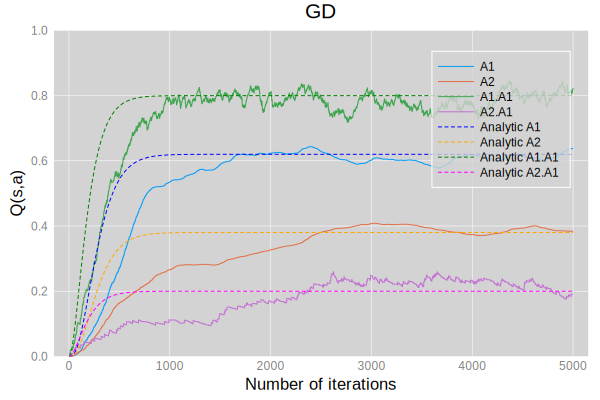

In [10]:
habitSimResults = plotSim(runHabit,N=5000,ana=false)
MFSimResults = plotSim(runMF,N=5000)
MBSimResults = plotSim(runMB,N=5000)
GDSimResults = plotSim(runGD,N=5000)

plth = habitSimResults[1]
pltf = MFSimResults[1]
pltb = MBSimResults[1]
pltg = GDSimResults[1]

<h2 align="center"> </h2>
<h2 align="center"> </h2>

<h1 align="center"> Reinforcement Learning Models for the Two Step Task </h1>

<h2 align="center"> </h2>
<h2 align="center"> </h2>


<h2 align="center"> Richard Fox</h2>

<h2 align="center"> </h2>

<h1 align="center"> Overview </h1>

- Two Step Task

- Existing Models 

  - Model-Free / Q-Learning
  - Model Based
  - Habitual

- Data Fitting 

  - Data Set
  - Maximum Likelihood Estimation

- Proposed Models 

  - Value Free
  - Hierarchical RL




<h1 align="center"> Two Step Task </h1>



<img align="center" src="files/TwoStepDiag.png" width="700" height="700">


<h1 align="center"> Model-Free / Q-Learning</h1>

$$Q(s, a) \leftarrow Q(s, a)+\alpha\left(r(s)+\gamma \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)-Q(s, a)\right)$$

<h1 align="center"> Habitual</h1>

$$h_{\tau+1}\left(s_{\tau}, a\right)=\left\{\begin{array}{ll}\left(1-\alpha_{H}\right){h_{\tau}\left(s_{\tau}, a\right)+\alpha_{H}} & { ; \quad a=a_{\tau}} \\ \left(1-\alpha_{H}\right){h_{\tau}\left(s_{\tau}, a\right)} & { ; \quad a \neq a_{\tau}}\end{array}\right.$$

<h1 align="center"> Model Based</h1>

$$Q(s, a) \leftarrow Q(s, a)+\alpha\left(r(s)+\gamma \sum_{s^{\prime}}T\left(s_{\tau}, a_{\tau}, s^{\prime}\right)\max_{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)-Q(s, a)\right)$$

<h2 align="center">Transition Model</h2>

$$T_{\tau+1}\left(s_{\tau}, a_{\tau}, s^{\prime}\right)=\left\{\begin{array}{ll}\left(1-\alpha_{T}\right){T_{\tau}\left(s_{\tau}, a_{\tau}, s^{\prime}\right)+\alpha_{T}} & {;} & {\mathrm{s}^{\prime}=s_{\tau+1}} \\ \left(1-\alpha_{T}\right){T_{\tau}\left(s_{\tau}, a_{\tau}, s^{\prime}\right)} & { ;} & {\mathrm{s}^{\prime} \neq s_{\tau+1}}\end{array}\right.$$

# Q Value Time Series For Habitual and Model-Free Controllers

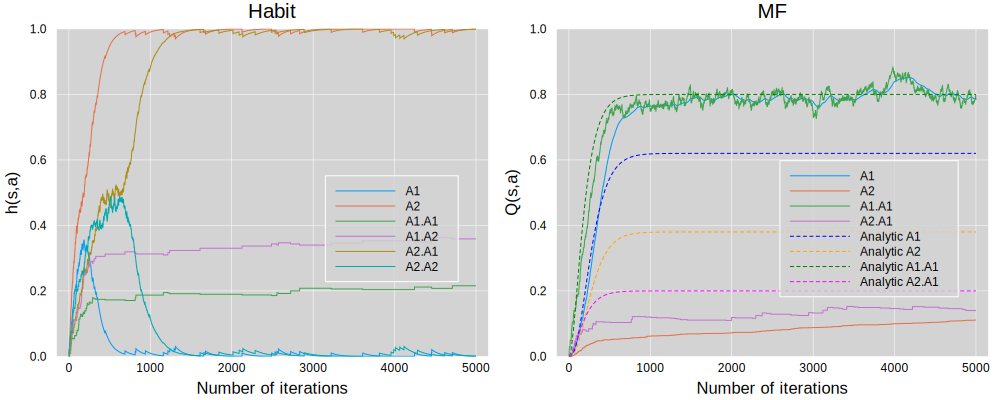

In [20]:
plot(habitSimResults[1], MFSimResults[1],size=(1000,400),legend=:right,legendfontsize=8,foreground_color_text=:black)

# Q Value and Transition Model Time Series For Model Based and Goal Directed Controllers

In [39]:
plot_MBGD = plot(MBSimResults[1], GDSimResults[1],MBSimResults[2],GDSimResults[2],size=(1000,600),foreground_color_text=:black,legend=:bottomright,legendfontsize=8)
show(Nothing())

nothing

In [40]:
plot_MBGD

# Final Values for Each Approach After 5000 iterations

In [58]:
plot_bar = plot(habitSimResults[3], MFSimResults[3],MBSimResults[3],GDSimResults[3], size=(1000,600),layout=@layout(bottom_margin=10mm),foreground_color_text=:black)
#show(Nothing())

ErrorException: unhandled layout type Measures.Length{:mm,Float64}: 10.0mm

In [47]:
plot_bar

MethodError: MethodError: no method matching +(::Measures.Length{:mm,Float64}, ::String)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:502
  +(::Measures.Length{U,T} where T, !Matched::Measures.Length{U,T} where T) where U at /home/rfox/.julia/packages/Measures/eNttC/src/length.jl:28
  +(::Measures.Measure, !Matched::Measures.Measure) at /home/rfox/.julia/packages/Measures/eNttC/src/operations.jl:41

# Data Set

- 112 Participants
- 200 trials with randomly changing terminal P values
- interlaced with cued trials to aim for a particular terminal node

# Fitting

- Maximum Likelihood Estimation
-